# Кейс №6

## Прогнозирование исходов заболевания циррозом печени с помощью ML

## Участники:

- Алёна Лозинская
- Валентина Кулакова
- Дмитрий Волобуев
- Артур Григорян
- Ильсия Коткова
- Матвей Радаев

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, FunctionTransformer, PolynomialFeatures
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [2]:
pd.set_option('display.max_columns', None)
plt.style.use("default")
sns.set_palette("Set2")

RANDOM_STATE = 42
TARGET_COL = "Status"
DROP_COL = ["id", "N_Days"]

Признак N_Days исключён, поскольку он приводит к ликам. Это значение всегда указывается постфактум вместе с таргетом. Если наша цель — создание "честной" медицинской ML-модели, то на момент прогнозирования вероятности исхода заболевания мы ничего не знаем о том, сколько дней проживёт пациент.

# Этап I. Предобработка данных для ML

## 1. Загрузка и сплит данных

Загрузим данные, разделим наши признаки на числовые и категориальные, преобразуем таргет в бинарный, разделим на train и test.

In [3]:
df = pd.read_csv("../../data/train.csv").drop(columns=DROP_COL)

In [4]:
target_maps = {"C": 0, "D": 1}

binary_maps = {
    "Drug": {"Placebo": 0, "D-penicillamine": 1},
    "Sex": {"F": 0, "M": 1},
    "Ascites": {"N": 0, "Y": 1},
    "Hepatomegaly": {"N": 0, "Y": 1},
    "Spiders": {"N": 0, "Y": 1}
}

binary_features = list(binary_maps.keys())
multi_category_features = ["Edema", "Stage"]

numeric_features = ["Age", "Bilirubin", "Cholesterol", "Albumin", "Copper",
                    "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin"]

skewed_numeric = ["Bilirubin", "Cholesterol", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Prothrombin"]

symmetric_numeric = [col for col in numeric_features if col not in skewed_numeric]

Исходный таргет с тремя категориями преобразуем в две и будем решать задачу бинарной классификации.

Класс CL означает, что пациент выжил благодаря трансплантации печени. А информации о том, кому была сделана или назначена трансплантация, в данных нет. Поэтому мы не можем корректно предсказать событие CL по исходным биохимическим показателям - оно зависит не только от тяжести болезни, но и от внешних факторов (решение врача, наличие органа, успешность операции). Среди представителей класса D также могли быть пациенты, которые перенесли трансплантацию печени, равно как и в классе C могут быть пациенты, которым предстоит операция, но мы об этом не знаем. Кроме того, CL очень малочисленный: всего 3.5% против 33.7% и 62.8% классов D и C соответственно. Поэтому его разумно исключить и решать задачу в виде бинарной классификации:

- Класс 0, умеренная стадия заболевания — C (пациент жив)
- Класс 1, тяжёлая стадия заболевания — D (летальный исход)

In [5]:
df = df[df[TARGET_COL] != 'CL'].reset_index(drop=True)

df[TARGET_COL] = df[TARGET_COL].map(target_maps)

Наблюдаем выраженный дисбаланс классов: только более трети пациентов страдают тяжёлой формой заболевания. Это будет учтено при обучении ML-модели и оценке качества.  

In [6]:
df[TARGET_COL].value_counts(normalize=True)

Status
0    0.650721
1    0.349279
Name: proportion, dtype: float64

Разделим все данные на train и test. Подбор методов обработки признаков, настройку гиперпараметров и оценку качества будем проводить только на кросс-валидации на train. Test служит для финальной оценки качества лучшей модели.

In [7]:
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

In [8]:
print("Распределение таргета на train:")
print(y_train.value_counts(normalize=True))

print("=="*25)

print("Распределение таргета на test:")
print(y_test.value_counts(normalize=True))

Распределение таргета на train:
Status
0    0.650721
1    0.349279
Name: proportion, dtype: float64
Распределение таргета на test:
Status
0    0.650721
1    0.349279
Name: proportion, dtype: float64


## 2. Функции для предобработки и FE

Напишем классы-преобразователи для переменных разных типов.

In [9]:
class BinaryMapper(BaseEstimator, TransformerMixin):
    """
    Превращает бинарные категориальные в 0/1 по заданному словарю.
    """
    def __init__(self, mapping: dict):
        self.mapping = mapping
        self.columns_ = list(mapping.keys())

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_df = X.copy() if isinstance(X, pd.DataFrame) else pd.DataFrame(X, columns=self.columns_)
        for col, mapping in self.mapping.items():
            X_df[col] = X_df[col].map(mapping)
        return X_df

    def get_feature_names_out(self, input_features=None):
        return self.columns_


class PercentileClipper(BaseEstimator, TransformerMixin):
    """Обрезает выбросы в указанных колонках по перцентилям."""
    def __init__(self, columns, lower=0.0, upper=99.5):
        self.columns = columns
        self.lower = lower
        self.upper = upper
        self.bounds_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X, columns=self.columns)
        for col in self.columns:
            low = np.percentile(X[col], self.lower)
            up = np.percentile(X[col], self.upper)
            self.bounds_[col] = (low, up)
        return self

    def transform(self, X):
        X_df = pd.DataFrame(X, columns=self.columns)
        for col, (low, up) in self.bounds_.items():
            X_df[col] = X_df[col].clip(low, up)
        return X_df.values
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return np.array(self.columns, dtype=object)
        return np.asarray(input_features, dtype=object)

Создадим функцию, которая формирует пайплайн предобработки признаков с разными видами преобразований.

Ниже указаны четыре стратегии предобработки числовых признаков, которые имеют скошенное распределение с выбросами:

- Вариант 1: log + standard scaler
- Вариант 2: log + percentile clip + standard scaler
- Вариант 3: log + robust scaler
- Вариант 4: log + percentile clip + robust scaler

**Log-преобразование** стабилизирует дисперсию и уменьшает асимметрию, делает данные более нормальными.

**Percentile Clipper** обрезает экстремальные выбросы по перцентилям (в нашем случае — длинные правые хвосты), защищает от сильного влияния аномалий.

**Standard Scaler** стандартизует данные (среднее=0, дисперсия=1), хорошо подходит для нормально распределённых данных.

**Robust Scaler** масштабирует на основе медианы и межквартильного расстояния, более устойчив к выбросам.

Для симметричных числовых признаков используется только скейлер.

Бинарные признаки кодируются как 0 и 1, мультикатегориальные через one-hot-encoding.

Также создаётся отдельный преобразователь для полиномиальных фичей, который включается по флагу.

In [10]:
class PolyFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, degree=2, interaction_only=True, include_bias=False):
        self.degree = degree
        self.interaction_only = interaction_only
        self.include_bias = include_bias

    def fit(self, X, y=None):
        self.poly_ = PolynomialFeatures(
            degree=self.degree,
            interaction_only=self.interaction_only,
            include_bias=self.include_bias
        )
        self.poly_.fit(X)
        self.n_in_ = X.shape[1]
        return self

    def transform(self, X):
        Z = self.poly_.transform(X)
        return Z[:, self.n_in_:]

    def get_feature_names_out(self, input_features=None):
        names = self.poly_.get_feature_names_out(input_features)
        return np.asarray(names[self.n_in_:], dtype=object)


def make_poly_transformer(
    strategy,
    poly_skewed,
    poly_symmetric,
    poly_degree=2,
    interaction_only=True,
    clip_upper=99
):

    log = FunctionTransformer(np.log1p, feature_names_out="one-to-one")

    if strategy == "log_standard":
        skewed_pipe = Pipeline([("log", log)])
        symmetric_pipe = "passthrough"
        scaler = StandardScaler()

    elif strategy == "log_clip_standard":
        skewed_steps = [("log", log)]
        if len(poly_skewed) > 0:
            skewed_steps.append(("clip", PercentileClipper(poly_skewed, upper=clip_upper)))
        skewed_pipe = Pipeline(skewed_steps)
        symmetric_pipe = "passthrough"
        scaler = StandardScaler()

    elif strategy == "log_robust":
        skewed_pipe = Pipeline([("log", log)])
        symmetric_pipe = "passthrough"
        scaler = RobustScaler()

    elif strategy == "log_clip_robust":
        skewed_steps = [("log", log)]
        if len(poly_skewed) > 0:
            skewed_steps.append(("clip", PercentileClipper(poly_skewed, upper=clip_upper)))
        skewed_pipe = Pipeline(skewed_steps)
        symmetric_pipe = "passthrough"
        scaler = RobustScaler()

    else:
        raise ValueError(f"Unknown strategy: {strategy}")

    poly_numeric_prep = ColumnTransformer(
        transformers=[
            ("skewed", skewed_pipe, poly_skewed),
            ("symmetric", symmetric_pipe, poly_symmetric)
        ],
        remainder="drop",
        verbose_feature_names_out=False
    )

    return Pipeline([
        ("prep", poly_numeric_prep),
        ("poly", PolyFeatures(
            degree=poly_degree,
            include_bias=False,
            interaction_only=interaction_only
        )),
        ("scale", scaler)
    ])


def make_preprocessor(
    strategy="log_standard",
    skewed_numeric=skewed_numeric,
    symmetric_numeric=symmetric_numeric,
    binary_features=binary_features,
    multi_category_features=multi_category_features,
    use_poly=False,
    poly_skewed=None,
    poly_symmetric=None,
    poly_degree=2,
    interaction_only=True,
    clip_upper=99,
    proc_col_names=True
):
    log = FunctionTransformer(np.log1p, feature_names_out="one-to-one")

    if strategy == "log_standard":
        skewed_pipe = Pipeline([
            ("log", log),
            ("scale", StandardScaler())
        ])
        symmetric_pipe = Pipeline([("scale", StandardScaler())])

    elif strategy == "log_clip_standard":
        skewed_pipe = Pipeline([
            ("log", log),
            ("clip", PercentileClipper(skewed_numeric, upper=clip_upper)),
            ("scale", StandardScaler())
        ])
        symmetric_pipe = Pipeline([("scale", StandardScaler())])

    elif strategy == "log_robust":
        skewed_pipe = Pipeline([
            ("log", log),
            ("scale", RobustScaler())
        ])
        symmetric_pipe = Pipeline([("scale", RobustScaler())])

    elif strategy == "log_clip_robust":
        skewed_pipe = Pipeline([
            ("log", log),
            ("clip", PercentileClipper(skewed_numeric, upper=clip_upper)),
            ("scale", RobustScaler())
        ])
        symmetric_pipe = Pipeline([("scale", RobustScaler())])

    else:
        raise ValueError(f"Unknown strategy: {strategy}")

    transformers = [
        ("num_skewed", skewed_pipe, skewed_numeric),
        ("num_symmetric", symmetric_pipe, symmetric_numeric),
        ("binary", BinaryMapper(binary_maps), binary_features),
        ("category", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"), multi_category_features),
    ]

    if use_poly:
        
        poly_pipe = make_poly_transformer(
            strategy=strategy,
            poly_skewed=poly_skewed,
            poly_symmetric=poly_symmetric,
            poly_degree=poly_degree,
            interaction_only=interaction_only,
            clip_upper=clip_upper
        )
        transformers.insert(2, ("poly", poly_pipe, poly_symmetric+poly_skewed))

    return ColumnTransformer(
        transformers=transformers,
        remainder="drop",
        verbose_feature_names_out=proc_col_names
    )

Добавим также кастомные фичи, которые основаны на медицинской практике и потенциально могут улучшить качество модели:


- Symptom_Score — это сумма клинических осложнений (асцит, гепатомегалия, сосудистые "звёздочки", отёки). Чем больше число, тем выраженнее декомпенсация цирроза и выше риск неблагоприятного исхода.

- Bilirubin_Albumin_Ratio — это отношение билирубина к альбумину. Билирубин растёт при холестазе и нарушении выведения желчи, а альбумин падает при снижении синтетической функции печени. Поэтому высокий индекс указывает на тяжёлое поражение печени и более высокий риск плохого прогноза.


- CoagulationIndex — это отношение протромбина к альбумину. Оно отражает синтетическую функцию печени: при тяжёлом циррозе протромбиновое время растёт, а альбумин падает. Поэтому высокий индекс означает выраженную печёночную недостаточность и высокий риск неблагоприятного исхода. Эти параметры входят в шкалу Child-Pugh.


- Enzyme_Pattern — соотношение SGOT и щелочной фосфатазы отражает так называемый ферментный паттерн. Высокое значение указывает на гепатоцеллюлярное повреждение (клеточное воспаление), а низкое — на холестаз. В циррозе преобладание холестаза часто связано с более тяжёлым течением, поэтому этот индекс помогает дереву улавливать тип поражения печени.

In [11]:
class SymptomScoreTransformer(BaseEstimator, TransformerMixin):
    """
    Symptom_Score - суммарное кол-во осложнений (Ascites, Hepatomegaly, Spiders, Edema)
    """
    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.to_list()
        return self

    def transform(self, X):
        X = X.copy()
        mapping = {'N': 0, 'Y': 1, 'S': 1}

        ascites = X['Ascites'].map(mapping)
        hepatomegaly = X['Hepatomegaly'].map(mapping)
        spiders = X['Spiders'].map(mapping)
        edema = X['Edema'].map(mapping)

        X['Symptom_Score'] = ascites + hepatomegaly + spiders + edema
        return X
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        input_features = list(input_features)
        return np.array(input_features + ["Symptom_Score"], dtype=object)


class BilirubinAlbuminRatioTransformer(BaseEstimator, TransformerMixin):
    """
    Bilirubin_Albumin_Ratio = Bilirubin / Albumin
    """
    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.to_list()
        return self

    def transform(self, X):
        X = X.copy()
        eps = 1e-6
        X['Bilirubin_Albumin_Ratio'] = X['Bilirubin'] / (X['Albumin'] + eps)
        return X

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        return np.array(list(input_features) + ["Bilirubin_Albumin_Ratio"], dtype=object)
    

class CoagulationIndexTransformer(BaseEstimator, TransformerMixin):
    """
    Coagulation_Index = Prothrombin / Albumin (показатель синтетической функции печени)*
    """
    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.to_list()
        return self

    def transform(self, X):
        X = X.copy()
        eps = 1e-6
        X['Coagulation_Index'] = X['Prothrombin'] / (X['Albumin'] + eps)
        return X

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        return np.array(list(input_features) + ["Coagulation_Index"], dtype=object)
    

class EnzymePatternTransformer(BaseEstimator, TransformerMixin):
    """
    Добавляет Enzyme_Pattern = SGOT / Alk_Phos (тип поражения печени)*
    """
    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.to_list()
        return self

    def transform(self, X):
        X = X.copy()
        eps = 1e-6
        X['Enzyme_Pattern'] = X['SGOT'] / (X['Alk_Phos'] + eps)
        return X
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        return np.array(list(input_features) + ["Enzyme_Pattern"], dtype=object)

## 3. Функции визуализаций

Напишем вспомогательные функции для визуализаций:

- результаты преобразований асимметричных числовых признаков
- зависимость метрик модели от порога вероятности
- матрица ошибок
- коэффициенты логрега к признакам

In [12]:
def plot_skewed_changes(X_train, processed, features=skewed_numeric, bins=30):
    """
    Для каждого skewed признака:
    - слева оригинал
    - справа - версии после разных стратегий
    """
    n = len(features)
    fig, axes = plt.subplots(n, 1 + len(processed), figsize=(5*(1+len(processed)), 3*n), squeeze=False)

    for i, col in enumerate(features):
        ax = axes[i, 0]
        sns.histplot(X_train[col], bins=bins, ax=ax)
        ax.set_title(f"{col} (до)")

        for j, s in enumerate(processed.keys(), start=1):
            ax = axes[i, j]
            sns.histplot(processed[s][col], bins=bins, ax=ax)
            ax.set_title(f"{col} — {s}")

    plt.tight_layout()
    plt.show()
     

def plot_boxplots(X_train, processed, features=skewed_numeric):
    n = len(features)
    fig, axes = plt.subplots(n, 1+len(processed), figsize=(5*(1+len(processed)), 2.5*n), squeeze=False)

    for i, col in enumerate(features):
        axes[i, 0].boxplot(X_train[col], vert=True)
        axes[i, 0].set_title(f"{col} (до)")

        for j, s in enumerate(processed.keys(), start=1):
            axes[i, j].boxplot(processed[s][col].dropna(), vert=True)
            axes[i, j].set_title(f"{col} — {s}")

    plt.tight_layout()
    plt.show()
    
    
def summarize_changes(X_train, processed, numeric_features=numeric_features):
    print("\n=== СВОДКА ТРАНСФОРМАЦИЙ ЧИСЛОВЫХ ПРИЗНАКОВ ===\n")

    for col in numeric_features:
        print(f"\nПРИЗНАК: {col}")
        print(f"  • исходный skew: {X_train[col].skew():.2f}")

        for strat, df_proc in processed.items():
            s = df_proc[col]
            skew = s.skew()
            z = (s - s.mean()) / (s.std() + 1e-9)
            out = (np.abs(z) > 3).mean()

            print(f"    - {strat}: skew={skew:.2f}, доля выбросов(|z|>3)={out:.3f}")
            

def plot_threshold_curves(estimator, X, y, cv, title="Metrics vs Threshold"):

    if hasattr(estimator, "best_estimator_"):
        model = estimator.best_estimator_
    else:
        model = estimator

    y_proba = cross_val_predict(model, X, y, cv=cv, method="predict_proba", n_jobs=-1)[:, 1]

    thresholds = np.arange(0.1, 0.91, 0.05)
    recalls, precisions, f1s = [], [], []

    for thr in thresholds:
        y_thr = (y_proba >= thr).astype(int)
        recalls.append(recall_score(y, y_thr))
        precisions.append(precision_score(y, y_thr))
        f1s.append(f1_score(y, y_thr))

    plt.figure(figsize=(8, 4))
    plt.plot(thresholds, recalls, label="Recall")
    plt.plot(thresholds, precisions, label="Precision")
    plt.plot(thresholds, f1s, label="F1")
    plt.xlabel("Probability Threshold")
    plt.ylabel("Metric")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix_simple(y_true, y_pred, title="Confusion Matrix"):
    
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    
    
def plot_logreg_feature_coef(model, top_n=None, title="Feature Coefs (LR)"):

    if hasattr(model, "best_estimator_"):
        pipe = model.best_estimator_
    else:
        pipe = model

    preprocess = pipe.named_steps["preprocess"]
    feature_names = preprocess.get_feature_names_out()

    logreg = pipe.named_steps["logreg"]
    coefs = logreg.coef_[0]

    fi = pd.DataFrame(
            {"feature": feature_names, "coef": coefs}
        ).assign(abs_coef=lambda d: d["coef"].abs()).sort_values("abs_coef", ascending=False)

    if top_n is not None:
        fi = fi.head(top_n)

    plt.figure(figsize=(10, 16))
    sns.barplot(data=fi, x="coef", y="feature")
    plt.xlabel("Coef")
    plt.ylabel("Feature")
    plt.title(title)
    plt.grid(axis="x", alpha=0.3)
    plt.tight_layout()
    plt.show()

    return fi

## 4. Функции пайплайна

Функция пайплайна, которая позволяет перебирать не только гиперпараметры модели через GridSearch, но и методы борьбы с дисбалансом классов (RandomUnderSampler, RandomOverSampler, SMOTE) и стратегию предобработки числовых признаков. Функция также принимает на вход список фичей, с которыми будет работать модель, и флаги use_fe и use_poly, отвечающие за использования кастомных и полиномиальных фичей соответственно.

In [13]:
def make_lr_gridsearch(
    use_fe=False,
    fe_cols=None,
    strategy_list=("log_standard", "log_clip_standard", "log_robust", "log_clip_robust"),
    skewed_numeric=skewed_numeric,
    symmetric_numeric=symmetric_numeric,
    binary_features=binary_features,
    multi_category_features=multi_category_features,
    use_poly=False,
    poly_skewed=None,
    poly_symmetric=None,
    poly_degree=2,
    interaction_only=True,
    clip_upper=99
):

    preprocessors = []
    for strat in strategy_list:
        preproc = make_preprocessor(
            strategy=strat,
            skewed_numeric=skewed_numeric,
            symmetric_numeric=symmetric_numeric,
            binary_features=binary_features,
            multi_category_features=multi_category_features,
            use_poly=use_poly,
            poly_skewed=poly_skewed,
            poly_symmetric=poly_symmetric,
            poly_degree=poly_degree,
            interaction_only=interaction_only,
            clip_upper=clip_upper,
        )
        preproc._strategy_name = strat
        preprocessors.append(preproc)

    samplers = [
        "passthrough",
        RandomUnderSampler(random_state=RANDOM_STATE),
        RandomOverSampler(random_state=RANDOM_STATE),
        SMOTE(random_state=RANDOM_STATE, k_neighbors=5),
    ]

    lr = LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1, max_iter=300)

    steps = []
    if use_fe:

        if not fe_cols:
            fe_cols = ["Symptom_Score", "Bilirubin_Albumin_Ratio", "Coagulation_Index", "Enzyme_Pattern"]

        if "Symptom_Score" in fe_cols:
            steps.append(("symptom_score", SymptomScoreTransformer()))
        if "Bilirubin_Albumin_Ratio" in fe_cols:
            steps.append(("bilirubin_albumin_ratio", BilirubinAlbuminRatioTransformer()))
        if "Coagulation_Index" in fe_cols:
            steps.append(("coagulation_index", CoagulationIndexTransformer()))
        if "Enzyme_Pattern" in fe_cols:
            steps.append(("enzyme_pattern", EnzymePatternTransformer()))

    steps.extend([
        ("preprocess", preprocessors[0]),
        ("sampler", "passthrough"),
        ("logreg", lr)
    ])

    pipe = ImbPipeline(steps)

    param_grid = {
        "preprocess": preprocessors,
        "sampler": samplers,
        "logreg__C": [0.01, 0.05, 0.1, 0.2, 0.3],
        "logreg__l1_ratio": [0, 0.25, 0.5, 0.625, 0.75, 1],
        "logreg__penalty": ["elasticnet"],
        "logreg__solver": ["saga"],
        "logreg__class_weight": [None, "balanced"],
    }

    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=skf,
        scoring="recall",
        n_jobs=-1,
        verbose=1
    )

    return gs


def print_best_lr_params(gs):
    best = gs.best_params_

    preproc = best["preprocess"]
    sampler = best["sampler"]

    strategy = getattr(preproc, "_strategy_name", "unknown")

    if sampler == "passthrough":
        sampler_name = "no sampling"
    elif isinstance(sampler, RandomUnderSampler):
        sampler_name = "RandomUnderSampler"
    elif isinstance(sampler, RandomOverSampler):
        sampler_name = "RandomOverSampler"
    elif isinstance(sampler, SMOTE):
        sampler_name = "SMOTE"
    else:
        sampler_name = str(sampler)

    print("Лучший результат общего пайплайна (LR):")
    print(f"Стратегия препроцессинга: {strategy}")
    print(f"Семплирование: {sampler_name}")
    print(f"C: {best['logreg__C']}")
    print(f"l1_ratio: {best['logreg__l1_ratio']}")
    print(f"penalty: {best['logreg__penalty']}")
    print(f"solver: {best['logreg__solver']}")
    print(f"class_weight: {best['logreg__class_weight']}")

## 5. Демо предобработки

Чтобы убедиться, что преобразователи работают корректно, применим разные стратегии к X_train, выведем графики и статистики.

In [14]:
STRATEGIES = ["log_standard", "log_clip_standard", "log_robust", "log_clip_robust"]

def apply_strategies(X_train, strategies=STRATEGIES):
    outputs = {}
    for s in strategies:
        processor = make_preprocessor(s, proc_col_names=False)
        X_proc = processor.fit_transform(X_train)
        cols = processor.get_feature_names_out()
        outputs[s] = pd.DataFrame(X_proc, columns=cols, index=X_train.index)
    return outputs

In [15]:
processed = apply_strategies(X_train)

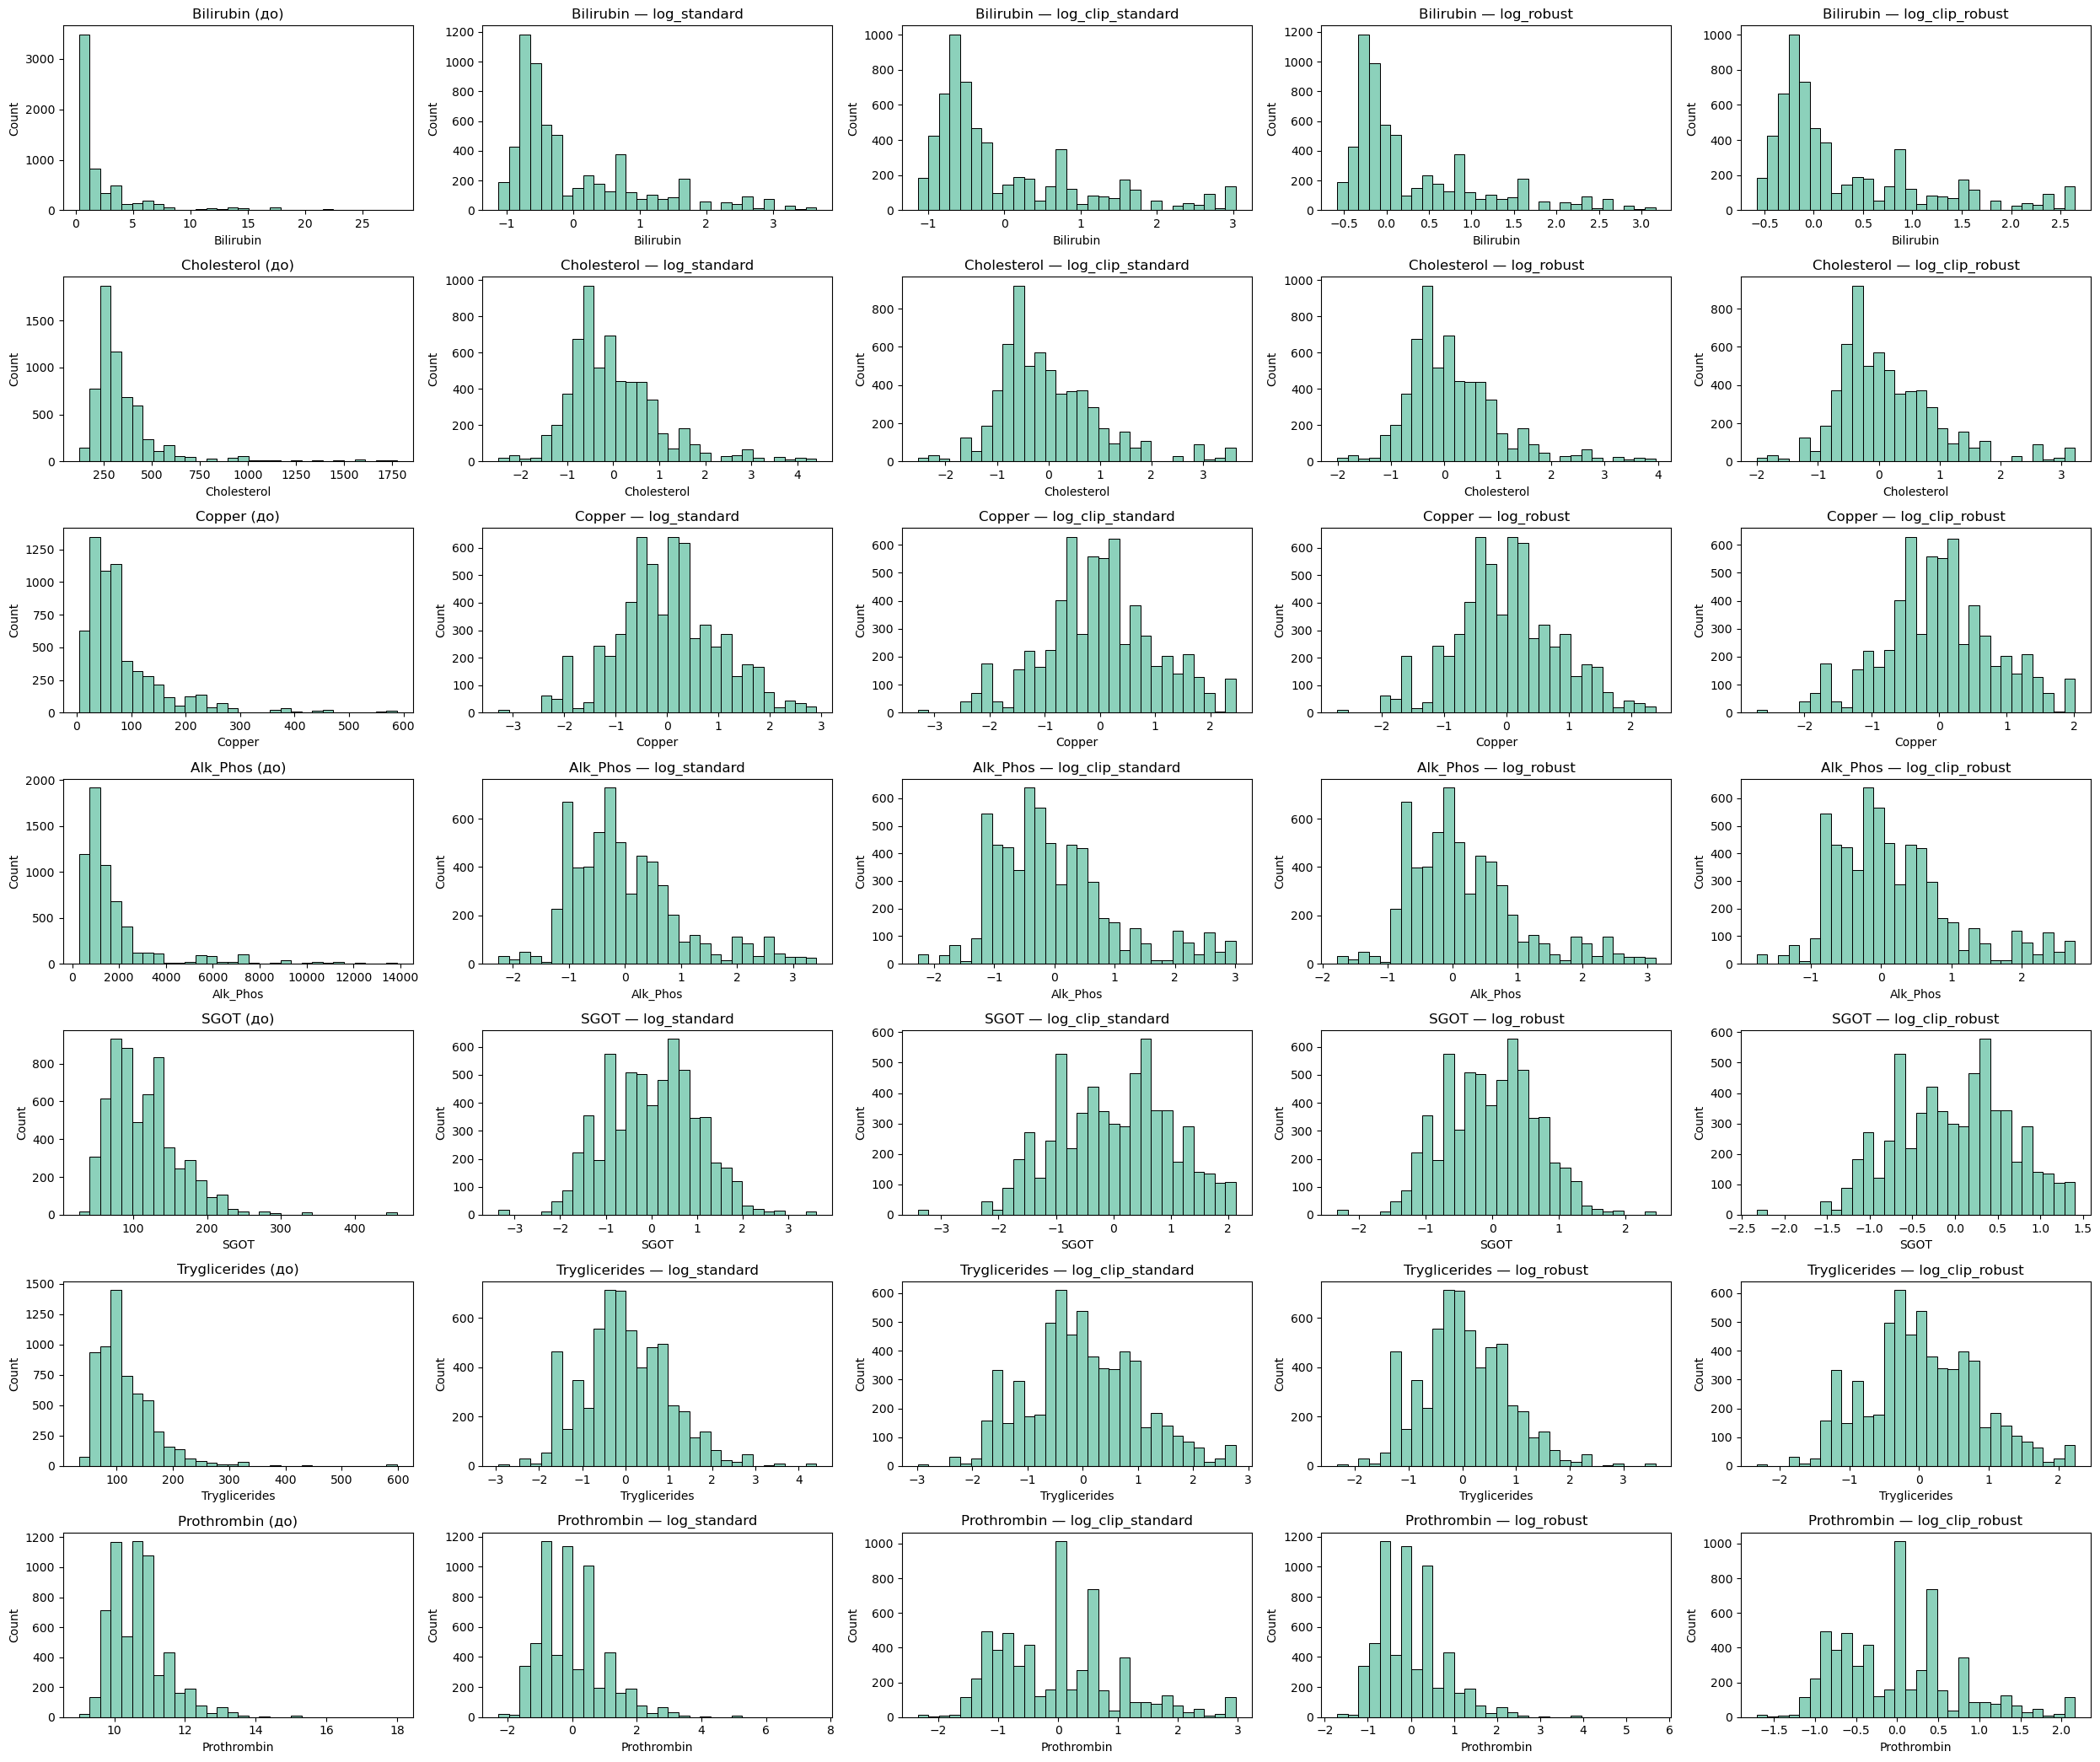

In [16]:
plot_skewed_changes(X_train, processed)

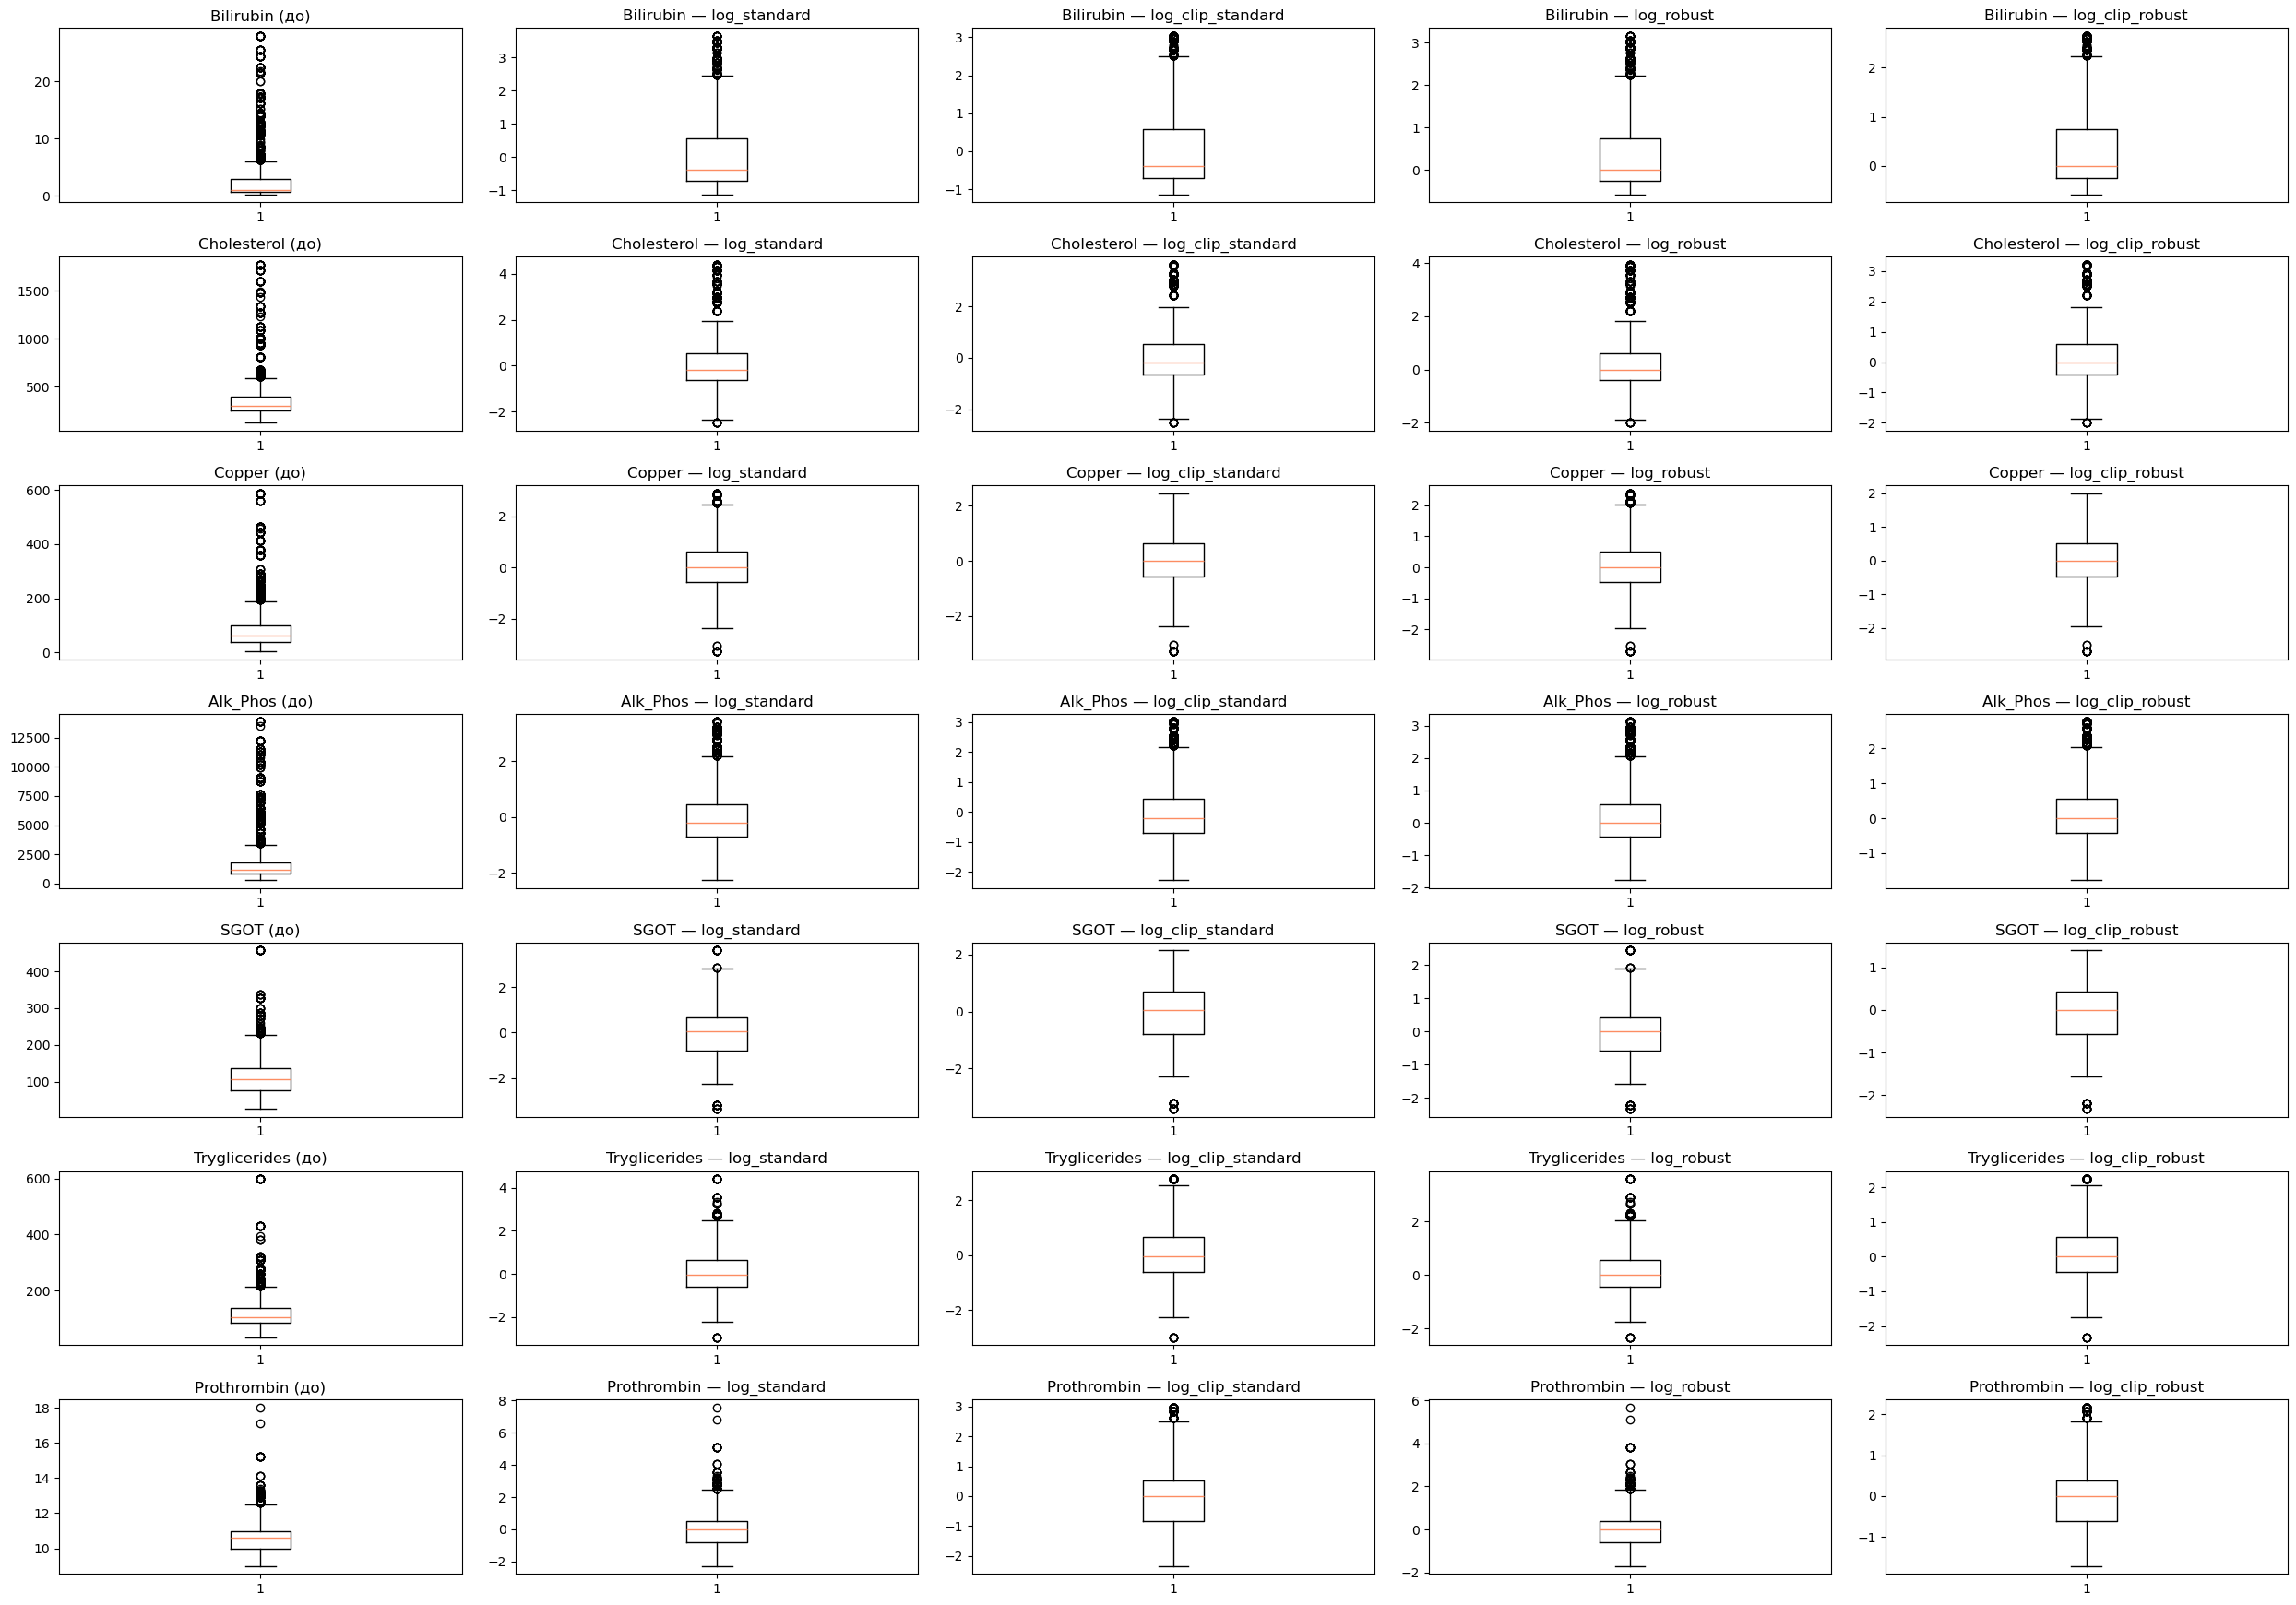

In [17]:
plot_boxplots(X_train, processed)

In [18]:
summarize_changes(X_train, processed)


=== СВОДКА ТРАНСФОРМАЦИЙ ЧИСЛОВЫХ ПРИЗНАКОВ ===


ПРИЗНАК: Age
  • исходный skew: 0.07
    - log_standard: skew=0.07, доля выбросов(|z|>3)=0.000
    - log_clip_standard: skew=0.07, доля выбросов(|z|>3)=0.000
    - log_robust: skew=0.07, доля выбросов(|z|>3)=0.000
    - log_clip_robust: skew=0.07, доля выбросов(|z|>3)=0.000

ПРИЗНАК: Bilirubin
  • исходный skew: 3.30
    - log_standard: skew=1.44, доля выбросов(|z|>3)=0.010
    - log_clip_standard: skew=1.38, доля выбросов(|z|>3)=0.012
    - log_robust: skew=1.44, доля выбросов(|z|>3)=0.010
    - log_clip_robust: skew=1.38, доля выбросов(|z|>3)=0.012

ПРИЗНАК: Cholesterol
  • исходный skew: 3.63
    - log_standard: skew=1.26, доля выбросов(|z|>3)=0.015
    - log_clip_standard: skew=1.12, доля выбросов(|z|>3)=0.017
    - log_robust: skew=1.26, доля выбросов(|z|>3)=0.015
    - log_clip_robust: skew=1.12, доля выбросов(|z|>3)=0.017

ПРИЗНАК: Albumin
  • исходный skew: -0.58
    - log_standard: skew=-0.58, доля выбросов(|z|>3)=0.015
    - 

На графиках видно, что логарифмирование снижает правую асимметрию признаков и "сжимает" длинные хвосты, клиппинг (в нашем случае винзоризация) убирает единичные экстремальные значения, которые непропорционально влияют на оценку коэффициентов, а StandardScaler или RobustScaler приводит все признаки к сопоставимому масштабу. В результате распределения становятся ближе к симметричным, доля выбросов снижается до долей процентов, что делает наши данные более подходящими для обучения и интерпретации логистической регрессии.

Посмотрим, как будет выглядеть предобработанный датасет после указанных выше преобразований. Покажем на примере исходного набора признаков и полиномиальных фичей.

In [19]:
preprocessor = make_preprocessor("log_clip_standard")

In [20]:
df_proc = pd.DataFrame(preprocessor.fit_transform(X_train), columns=preprocessor.get_feature_names_out())

In [21]:
df_proc.head()

,num_skewed__Bilirubin,num_skewed__Cholesterol,num_skewed__Copper,num_skewed__Alk_Phos,num_skewed__SGOT,num_skewed__Tryglicerides,num_skewed__Prothrombin,num_symmetric__Age,num_symmetric__Albumin,num_symmetric__Platelets,binary__Drug,binary__Sex,binary__Ascites,binary__Hepatomegaly,binary__Spiders,category__Edema_S,category__Edema_Y,category__Stage_2.0,category__Stage_3.0,category__Stage_4.0
0,0.365671,1.416713,0.817915,-0.049729,0.847200,0.831303,0.134652,-1.680801,0.151520,0.296398,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.808440,0.328017,-0.216828,-0.102753,0.899275,1.486451,-0.982436,0.021346,1.017782,-1.006539,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2.995877,-1.554002,2.466007,-0.787794,1.389449,1.527506,2.965277,-0.377052,-2.302889,-0.868174,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
3,2.525029,0.116510,0.430788,0.150109,0.627402,-0.070790,0.533971,-0.429158,0.151520,0.134972,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.638962,0.427694,0.664009,-0.471459,0.509857,-0.147094,0.664862,0.079423,0.555776,0.008138,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [22]:
df_proc.shape

(6104, 20)

In [23]:
df_proc.describe().T

,count,mean,std,min,25%,50%,75%,max
num_skewed__Bilirubin,6104.0,-1.292108e-16,1.000082,-1.131869,-0.714008,-0.384863,0.579382,3.037639
num_skewed__Cholesterol,6104.0,-8.916706e-16,1.000082,-2.535609,-0.645027,-0.165635,0.537152,3.637798
num_skewed__Copper,6104.0,3.026558e-16,1.000082,-3.301729,-0.584547,0.009024,0.638636,2.466007
num_skewed__Alk_Phos,6104.0,-5.948351e-16,1.000082,-2.269281,-0.707868,-0.203528,0.459455,3.015599
num_skewed__SGOT,6104.0,1.070936e-16,1.000082,-3.405858,-0.802868,0.048940,0.684177,2.136337
num_skewed__Tryglicerides,6104.0,4.714446e-16,1.000082,-2.985370,-0.596702,-0.045843,0.666602,2.776406
num_skewed__Prothrombin,6104.0,-1.456240e-15,1.000082,-2.341653,-0.838396,-0.000733,0.533971,2.965277
num_symmetric__Age,6104.0,-1.277557e-16,1.000082,-2.394281,-0.765137,0.081052,0.614330,2.776208
num_symmetric__Albumin,6104.0,-8.291023e-16,1.000082,-4.584045,-0.570365,0.093769,0.642402,3.154562
num_symmetric__Platelets,6104.0,2.165153e-16,1.000082,-2.344068,-0.614505,-0.003393,0.596189,3.432672


In [25]:
poly_skewed = ["Bilirubin", "Copper"]
poly_symmetric = ["Albumin"]
preprocessor_poly = make_preprocessor("log_clip_standard",
                                      use_poly=True,
                                      poly_skewed=poly_skewed,
                                      poly_symmetric=poly_symmetric,
                                      interaction_only=False)

In [26]:
df_proc_poly = pd.DataFrame(preprocessor_poly.fit_transform(X_train), columns=preprocessor_poly.get_feature_names_out())

In [27]:
df_proc_poly.head()

,num_skewed__Bilirubin,num_skewed__Cholesterol,num_skewed__Copper,num_skewed__Alk_Phos,num_skewed__SGOT,num_skewed__Tryglicerides,num_skewed__Prothrombin,num_symmetric__Age,num_symmetric__Albumin,num_symmetric__Platelets,poly__Bilirubin^2,poly__Bilirubin Copper,poly__Bilirubin Albumin,poly__Copper^2,poly__Copper Albumin,poly__Albumin^2,binary__Drug,binary__Sex,binary__Ascites,binary__Hepatomegaly,binary__Spiders,category__Edema_S,category__Edema_Y,category__Stage_2.0,category__Stage_3.0,category__Stage_4.0
0,0.365671,1.416713,0.817915,-0.049729,0.847200,0.831303,0.134652,-1.680801,0.151520,0.296398,0.056665,0.427360,0.463679,0.779284,0.919543,0.106459,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.808440,0.328017,-0.216828,-0.102753,0.899275,1.486451,-0.982436,0.021346,1.017782,-1.006539,-0.617466,-0.723782,-0.760678,-0.301887,0.317595,1.045346,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2.995877,-1.554002,2.466007,-0.787794,1.389449,1.527506,2.965277,-0.377052,-2.302889,-0.868174,3.744414,3.831164,2.178618,2.906207,0.709421,-2.145827,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
3,2.525029,0.116510,0.430788,0.150109,0.627402,-0.070790,0.533971,-0.429158,0.151520,0.134972,2.862985,2.120900,2.838865,0.351829,0.532716,0.106459,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.638962,0.427694,0.664009,-0.471459,0.509857,-0.147094,0.664862,0.079423,0.555776,0.008138,1.465916,1.488606,2.000241,0.606059,1.001581,0.535259,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [28]:
df_proc_poly.shape

(6104, 26)

In [29]:
df_proc_poly.describe().T

,count,mean,std,min,25%,50%,75%,max
num_skewed__Bilirubin,6104.0,-1.292108e-16,1.000082,-1.131869,-0.714008,-0.384863,0.579382,3.037639
num_skewed__Cholesterol,6104.0,-8.916706e-16,1.000082,-2.535609,-0.645027,-0.165635,0.537152,3.637798
num_skewed__Copper,6104.0,3.026558e-16,1.000082,-3.301729,-0.584547,0.009024,0.638636,2.466007
num_skewed__Alk_Phos,6104.0,-5.948351e-16,1.000082,-2.269281,-0.707868,-0.203528,0.459455,3.015599
num_skewed__SGOT,6104.0,1.070936e-16,1.000082,-3.405858,-0.802868,0.048940,0.684177,2.136337
num_skewed__Tryglicerides,6104.0,4.714446e-16,1.000082,-2.985370,-0.596702,-0.045843,0.666602,2.776406
num_skewed__Prothrombin,6104.0,-1.456240e-15,1.000082,-2.341653,-0.838396,-0.000733,0.533971,2.965277
num_symmetric__Age,6104.0,-1.277557e-16,1.000082,-2.394281,-0.765137,0.081052,0.614330,2.776208
num_symmetric__Albumin,6104.0,-8.291023e-16,1.000082,-4.584045,-0.570365,0.093769,0.642402,3.154562
num_symmetric__Platelets,6104.0,2.165153e-16,1.000082,-2.344068,-0.614505,-0.003393,0.596189,3.432672


# Этап II. Применение логистической регрессии

Будем использовать StratifiedKFold, чтобы в каждом фолде была соблюдена пропорция классов. Установим 5 фолдов.

In [30]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

Какую метрику будем оптимизировать? Что для нас важнее — FP или FN?

FN — это пропуск тяжёлого пациента:

- потенциально пропущенная угроза жизни

- поздняя диагностика

- потеря шанса на трансплантацию

FP — это ложная отправка на более глубокое обследование:

- пациент пойдёт повторую диагностику

- это дополнительные затраты

Вывод: максимизируем recall, т.е. нужно снижать FN, пусть даже ценой большего количества FP. Иными словами, лучше проверить лишнего пациента, чем пропустить тяжёлого.

## 1. LR

In [31]:
gs_lr = make_lr_gridsearch(use_fe=False, use_poly=False)

gs_lr.fit(X_train, y_train)

print_best_lr_params(gs_lr)
print(f"Best Recall: {gs_lr.best_score_:.4f}")
print("="*50)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits
Лучший результат общего пайплайна (LR):
Стратегия препроцессинга: log_clip_standard
Семплирование: RandomUnderSampler
C: 0.2
l1_ratio: 0.75
penalty: elasticnet
solver: saga
class_weight: None
Best Recall: 0.7950


In [32]:
y_pred_lr = cross_val_predict(
    gs_lr.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Class report (LR best estimator):")
print(classification_report(y_train, y_pred_lr))

Class report (LR best estimator):
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      3972
           1       0.73      0.80      0.76      2132

    accuracy                           0.82      6104
   macro avg       0.81      0.82      0.81      6104
weighted avg       0.83      0.82      0.83      6104



В контексте задачи лучше всего себя показал пайплайн с **RandomUnderSampler**, **log_clip_standard** и регуляризацией. Модель достигает хорошего баланса по precision и recall.

Попробуем настроить порог вероятности, чтобы добиться нужного баланса FP/FN.

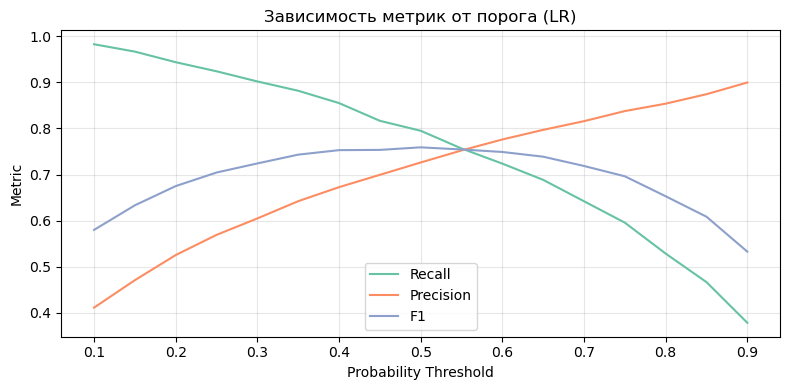

In [33]:
plot_threshold_curves(gs_lr.best_estimator_, X_train, y_train, cv=skf,
                      title="Зависимость метрик от порога (LR)")

Выполним новый предикт с выбранным порогом. Хотим найти как можно больше тяжёлых пациентов, но при этом избежать слишком большого кол-ва ложноположительных.

In [34]:
THRESHOLD = 0.3

y_proba_lr = cross_val_predict(gs_lr.best_estimator_, X_train, y_train, method="predict_proba", cv=skf, n_jobs=-1)[:, 1]
y_pred_lr_thr = (y_proba_lr >= THRESHOLD).astype(int)

print(f"Отчёт по классам (лучшая модель с порогом {THRESHOLD}):")
print(classification_report(y_train, y_pred_lr_thr))

Отчёт по классам (лучшая модель с порогом 0.3):
              precision    recall  f1-score   support

           0       0.93      0.68      0.79      3972
           1       0.60      0.90      0.72      2132

    accuracy                           0.76      6104
   macro avg       0.77      0.79      0.76      6104
weighted avg       0.82      0.76      0.77      6104



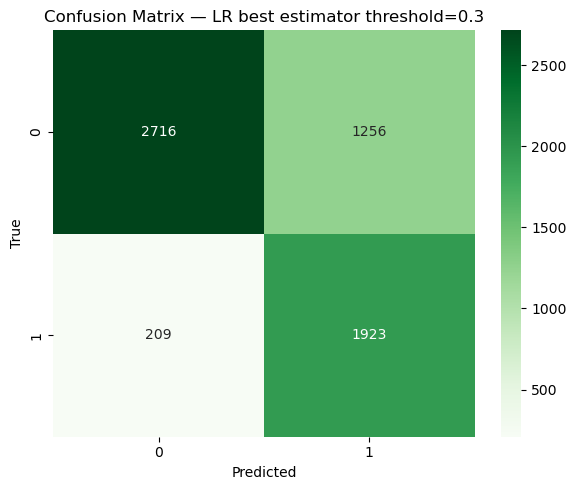

In [35]:
plot_confusion_matrix_simple(y_train, y_pred_lr_thr, title=f"Confusion Matrix — LR best estimator threshold={THRESHOLD}")

Модель с выбранным порогом достигает значения recall в 0.9, при этом сохраняет precision на приемлемом уровне (~0.6). Далее мы попробуем улучшить метрики, добавив дополнительные признаки в нашу модель.

## 2. LR + Feature Engineering

In [36]:
skewed_numeric_extended = skewed_numeric + ["Bilirubin_Albumin_Ratio", "Coagulation_Index", "Enzyme_Pattern"]
multi_category_features_extended = multi_category_features + ["Symptom_Score"]
poly_skewed = ["Bilirubin", "Copper", "Prothrombin"]
poly_symmetric = ["Albumin"]
fe_cols=["Symptom_Score", "Bilirubin_Albumin_Ratio", "Coagulation_Index", "Enzyme_Pattern"]

gs_lr_fe = make_lr_gridsearch(use_fe=True,
                              fe_cols=fe_cols,
                              skewed_numeric=skewed_numeric_extended,
                              multi_category_features=multi_category_features_extended,
                              use_poly=True,
                              poly_skewed=poly_skewed,
                              poly_symmetric=poly_symmetric,
                              poly_degree=2,
                              interaction_only=False)

gs_lr_fe.fit(X_train, y_train)

print_best_lr_params(gs_lr_fe)
print(f"Best Recall: {gs_lr_fe.best_score_:.4f}")
print("="*50)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits
Лучший результат общего пайплайна (LR):
Стратегия препроцессинга: log_clip_standard
Семплирование: RandomUnderSampler
C: 0.3
l1_ratio: 0.75
penalty: elasticnet
solver: saga
class_weight: None
Best Recall: 0.7974


In [37]:
y_pred_lr_fe = cross_val_predict(
    gs_lr_fe.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Class report (LR best estimator + FE):")
print(classification_report(y_train, y_pred_lr_fe))

Class report (LR best estimator + FE):
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      3972
           1       0.72      0.80      0.76      2132

    accuracy                           0.82      6104
   macro avg       0.80      0.82      0.81      6104
weighted avg       0.83      0.82      0.83      6104



Модель позволила немного увеличить recall, но при этом незначительно потерять в precision. Попробуем изменить порог вероятности.

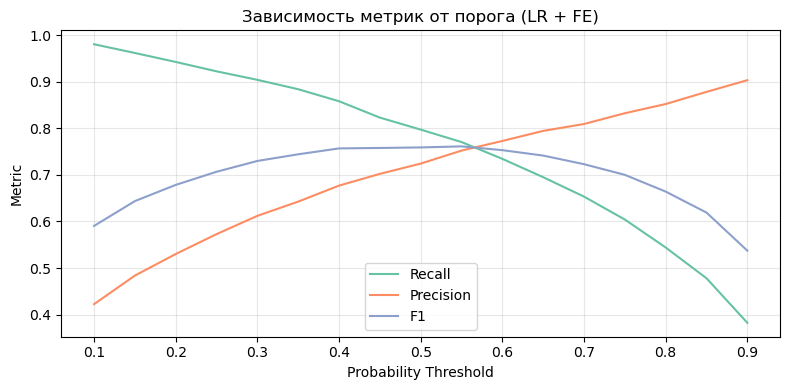

In [38]:
plot_threshold_curves(gs_lr_fe.best_estimator_, X_train, y_train, cv=skf,
                      title="Зависимость метрик от порога (LR + FE)")

In [39]:
THRESHOLD = 0.3

y_proba_lr_fe = cross_val_predict(gs_lr_fe.best_estimator_, X_train, y_train, method="predict_proba", cv=skf, n_jobs=-1)[:, 1]
y_pred_lr_fe_thr = (y_proba_lr_fe >= THRESHOLD).astype(int)

print(f"Отчёт по классам (лучшая модель с порогом {THRESHOLD} и FE):")
print(classification_report(y_train, y_pred_lr_fe_thr))

Отчёт по классам (лучшая модель с порогом 0.3 и FE):
              precision    recall  f1-score   support

           0       0.93      0.69      0.79      3972
           1       0.61      0.90      0.73      2132

    accuracy                           0.77      6104
   macro avg       0.77      0.80      0.76      6104
weighted avg       0.82      0.77      0.77      6104



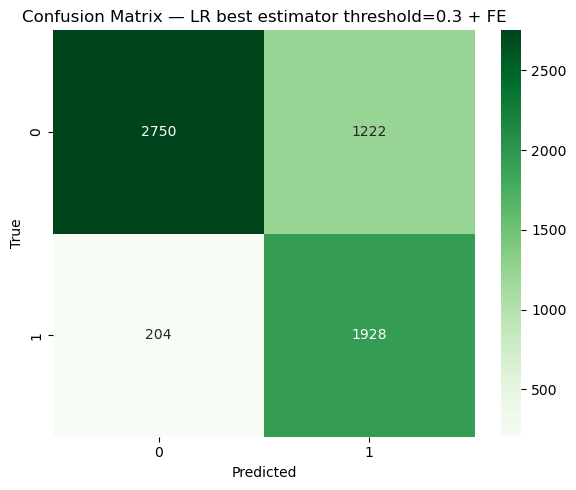

In [40]:
plot_confusion_matrix_simple(y_train, y_pred_lr_fe_thr, title=f"Confusion Matrix — LR best estimator threshold={THRESHOLD} + FE")

Видим, что feature engineering помог незначительно улучшить качество: recall по-прежнему находится на отметке 0.9, а precision вырос до 0.61. 

Теперь построим график коэффициентов логрега к признакам и попробуем исключить такие фичи, которые имеют коэффициенты, близкие к нулю, так как они практически не влияют на предсказание модели и лишь усложняют её без заметного прироста качества.

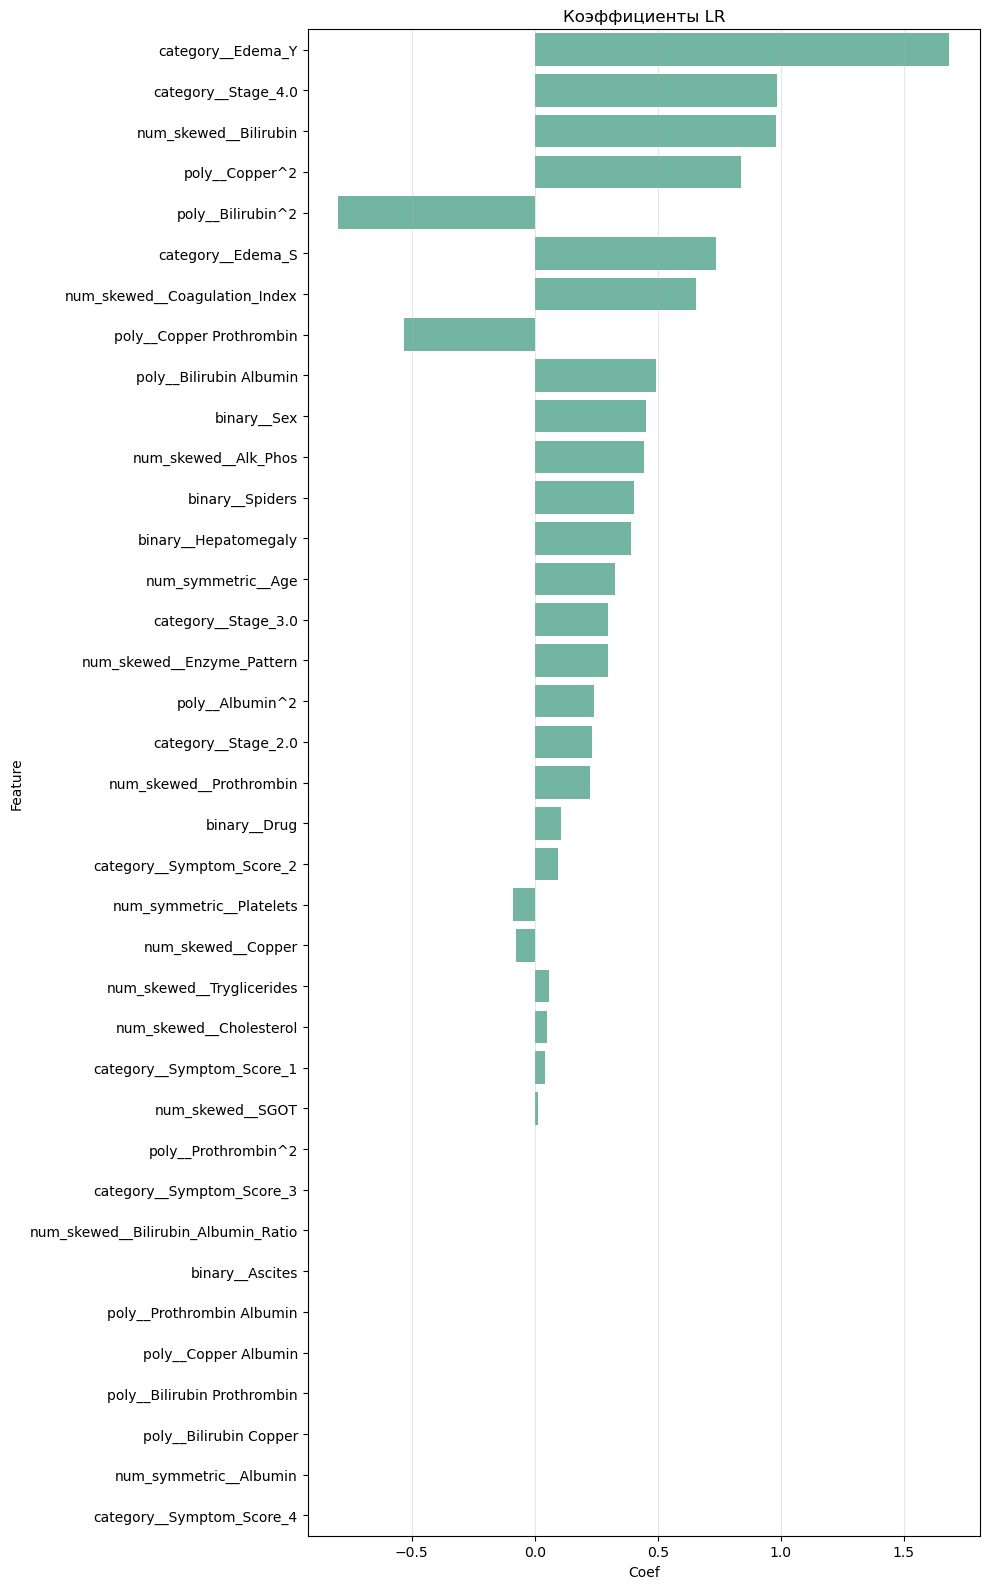

,feature,coef,abs_coef
29,category__Edema_Y,1.686441e+00,1.686441e+00
32,category__Stage_4.0,9.845479e-01,9.845479e-01
0,num_skewed__Bilirubin,9.794118e-01,9.794118e-01
17,poly__Copper^2,8.373780e-01,8.373780e-01
13,poly__Bilirubin^2,-7.993858e-01,7.993858e-01
28,category__Edema_S,7.370700e-01,7.370700e-01
8,num_skewed__Coagulation_Index,6.546817e-01,6.546817e-01
18,poly__Copper Prothrombin,-5.319761e-01,5.319761e-01
16,poly__Bilirubin Albumin,4.931050e-01,4.931050e-01
24,binary__Sex,4.519962e-01,4.519962e-01


In [41]:
plot_logreg_feature_coef(gs_lr_fe, top_n=None, title="Коэффициенты LR")

- Наибольший вклад в риск тяжёлого течения (класс 1) дают отёки: наличие Edema_Y резко повышает вероятность плохого прогноза.

- Дальше по силе идут маркеры стадии и лабораторные показатели: category__Stage_4.0, а также нелинейные варианты Copper и Bilirubin (poly__Copper^2, poly__Bilirubin^2) и кастомный признак num_skewed__Coagulation_Index.

- Остальные признаки (пол, "звёздочки", увеличение печени, возраст, Stage 2–3 и т.п.) дают умеренный/малый вклад.

- Есть ряд нулевых и почти нулевых признаков - после учёта ключевых факторов они почти не добавляют информации.

In [42]:
skewed_numeric_new = ['Bilirubin', 'Copper', 'Alk_Phos', 'SGOT', 'Prothrombin', 'Coagulation_Index', 'Enzyme_Pattern']
symmetric_numeric_new = ["Age"]
multi_category_features_new = ["Edema"]
poly_skewed_new = ["Bilirubin", "Copper"]
fe_cols_new = ["Coagulation_Index", "Enzyme_Pattern"]

gs_lr_fe_new = make_lr_gridsearch(use_fe=True,
                              fe_cols=fe_cols_new,
                              skewed_numeric=skewed_numeric_new,
                              symmetric_numeric=symmetric_numeric_new,
                              multi_category_features=multi_category_features_new,
                              use_poly=True,
                              poly_skewed=poly_skewed_new,
                              poly_symmetric=[],
                              poly_degree=2,
                              interaction_only=False)

gs_lr_fe_new.fit(X_train, y_train)

print_best_lr_params(gs_lr_fe_new)
print(f"Best Recall: {gs_lr_fe_new.best_score_:.4f}")
print("="*50)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits
Лучший результат общего пайплайна (LR):
Стратегия препроцессинга: log_clip_standard
Семплирование: SMOTE
C: 0.3
l1_ratio: 0.75
penalty: elasticnet
solver: saga
class_weight: None
Best Recall: 0.7969


In [43]:
y_pred_lr_fe_new = cross_val_predict(
    gs_lr_fe_new.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Class report (LR best estimator + FE, some features removed):")
print(classification_report(y_train, y_pred_lr_fe_new))

Class report (LR best estimator + FE, some features removed):
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      3972
           1       0.73      0.80      0.76      2132

    accuracy                           0.82      6104
   macro avg       0.81      0.82      0.81      6104
weighted avg       0.83      0.82      0.83      6104



Модель едва заметно потеряла в recall по сравнению с полным набором признаков, однако демонстрирует чуть более высокий precision.

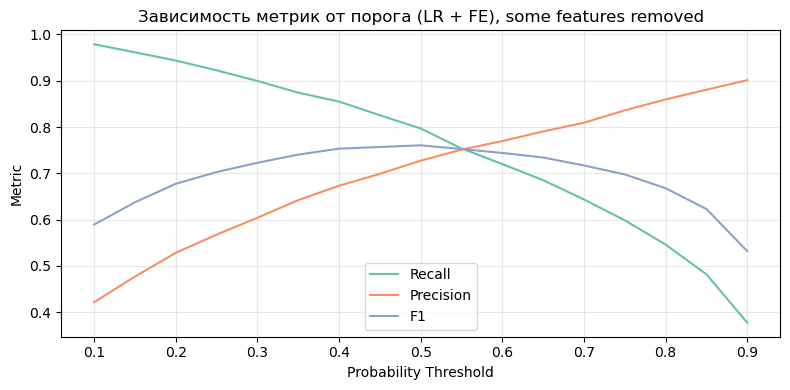

In [44]:
plot_threshold_curves(gs_lr_fe_new.best_estimator_, X_train, y_train, cv=skf,
                      title="Зависимость метрик от порога (LR + FE), some features removed")

In [47]:
THRESHOLD = 0.3

y_proba_lr_fe_new = cross_val_predict(gs_lr_fe_new.best_estimator_, X_train, y_train, method="predict_proba", cv=skf, n_jobs=-1)[:, 1]
y_pred_lr_fe_new_thr = (y_proba_lr_fe_new >= THRESHOLD).astype(int)

print(f"Отчёт по классам (лучшая модель с порогом {THRESHOLD} и FE):")
print(classification_report(y_train, y_pred_lr_fe_new_thr))

Отчёт по классам (лучшая модель с порогом 0.3 и FE):
              precision    recall  f1-score   support

           0       0.93      0.68      0.79      3972
           1       0.60      0.90      0.72      2132

    accuracy                           0.76      6104
   macro avg       0.77      0.79      0.75      6104
weighted avg       0.81      0.76      0.76      6104



При изменении порога она показывает такое же качество, как модель с исходным набором признаков, лишь незначительно уступая по precision модели с расширенным набором признаков.

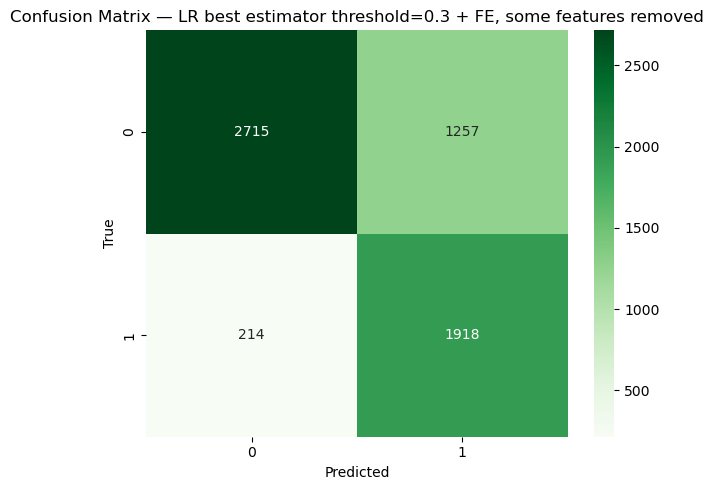

In [48]:
plot_confusion_matrix_simple(y_train, y_pred_lr_fe_new_thr,
                             title=f"Confusion Matrix — LR best estimator threshold={THRESHOLD} + FE, some features removed")

# Этап III. Проверка на тесте

В качестве лучшей модели выберем версию с сокращённым набором признаков, поскольку она демострирует практически такое же качество, как и остальные, однако обладает лучшей интерпретируемостью и позволяет эффективно сделать вывод о состоянии пациента по меньшему кол-ву данных.

In [53]:
THRESHOLD = 0.3

y_proba_lr_test = gs_lr_fe_new.best_estimator_.predict_proba(X_test)[:, 1]
y_pred_lr_test = (y_proba_lr_test >= THRESHOLD).astype(int)

In [54]:
print(f"Отчёт по классам на тесте (threshold={THRESHOLD}):")
print(classification_report(y_test, y_pred_lr_test))

Отчёт по классам на тесте (threshold=0.3):
              precision    recall  f1-score   support

           0       0.91      0.66      0.76       993
           1       0.58      0.89      0.70       533

    accuracy                           0.74      1526
   macro avg       0.75      0.77      0.73      1526
weighted avg       0.80      0.74      0.74      1526



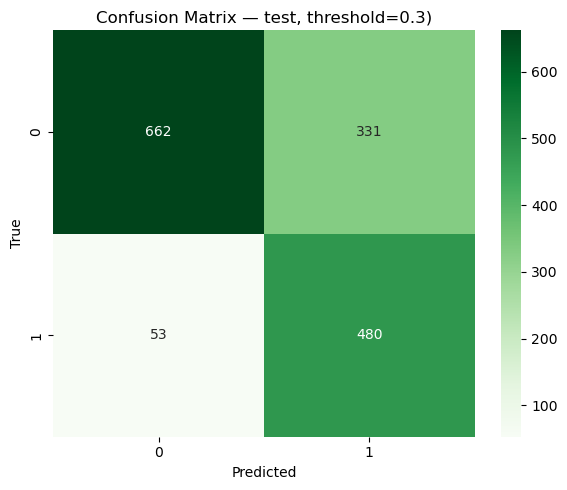

In [52]:
plot_confusion_matrix_simple(y_test, y_pred_lr_test,
                             title=f"Confusion Matrix — test, threshold={THRESHOLD})")

recall = 0.89 — модель находит подавляющее большинтво всех тяжёлых пациентов.
precision = 0.58 — чуть более 40% помеченных как тяжёлые окажутся не тяжёлыми => их можно отправлять на дообследование.

Для класса 0 (нет тяжёлого течения):
precision = 0.91 — если модель говорит, что тяжёлого течения нет, ей почти всегда можно доверять.

Вывод: при пороге 0.3 модель настроена как "скрининговая": она делает упор на минимизацию пропусков тяжёлых случаев, сознательно допуская больше ложноположительных, которых можно отфильтровать на этапе углублённой диагностики.

## Выводы

**Моделирование**

Наилучшие результаты показала логистическая регрессия с elasticnet-регуляризацией, обученная со следующими настройками:

- стратегия препроцессинга: log_clip_standard

- балансировка классов: SMOTE

- penalty = elasticnet, solver = saga

- C = 0.3, l1_ratio = 0.75

- оптимизация по recall для положительного класса

- порог классификации = 0.3

**Feature engineering**

В ходе работы был выполнен осмысленный feature engineering, включающий:

- построение клинически интерпретируемых индексов (например, Coagulation_Index, Bilirubin_Albumin_Ratio)

- добавление полиномиальных признаков для улавливания сложных зависимостей

Анализ коэффициентов модели позволил провести отбор фичей и сократить набор признаков без заметной потери качества. Итоговая модель использует меньшее число признаков, при этом остаётся устойчивой и интерпретируемой, что повышает её практическую ценность.

**Результаты:**

Качество на тестовой выборке

На тестовой выборке модель показала следующие результаты (threshold = 0.3):

- Recall класса 1: 0.89

- Precision класса 1: 0.58

Модель уверенно выявляет большинство пациентов с неблагоприятным исходом, что достигается ценой увеличения числа ложноположительных срабатываний. Такой компромисс является оправданным для медицинской задачи, где пропуск тяжёлого пациента значительно более критичен, чем ложная тревога.